In [1]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [2]:
# import necessary packages:
import numpy as np
import pandas as pd
import pycocotools
from engine import evaluate
import utils
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.utils import draw_bounding_boxes
from torchvision.models import detection
from torchvision import transforms as T
from torchvision import datasets, models
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, sampler, random_split
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import math
import cv2
import os
import json
import sys

In [6]:
# define detection dataset class
# it inherit from torch datasets:
class DetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None, transforms=None):
        self.transforms = transforms
        self.target_transform = target_transform
        self.transform = transform
        self.root = root
        self.coco = COCO(os.path.join(root, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    # load image using index using OpenCV, and convert it from BGR to RGB
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']        
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    # load image informations like annotations, id, etc.
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    # override __getitem__ method of dataset class
    def __getitem__(self, index):
        id = self.ids[index]

        #! first we load image and targets:
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        #! if there is a transformation in input arguments we must
        #! apply that transformation on both bounding boxes and image
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        else:
            transformed = {
                'image': torch.from_numpy(image),
                'bboxes': boxes
            }

        image = transformed['image']
        boxes = transformed['bboxes']
        
        #! we must convert bounding boxes from coco format to pascal format
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        #! now we create target dictionary as our pretrained network output format
        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([index])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        # finally, we normalize our image by dividing it to 255
        return image.div(255).permute(2, 0, 1), targ
    
    def __len__(self):
        return len(self.ids)

def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
os.system('cls')
# clear cuda cache:
torch.cuda.empty_cache()
#! declare our Device, if we use GPU or CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# defining dataset path:
train_dataset_path = '/content/drive/MyDrive/lung cancer.v2-lung.coco.zip (Unzipped Files)/train/'
test_dataset_path = '/content/drive/MyDrive/lung cancer.v2-lung.coco.zip (Unzipped Files)/test/'
#! load dataset informations based on annotations.coco.json
coco_train = COCO(os.path.join(train_dataset_path, "_annotations.coco.json"))
coco_test = COCO(os.path.join(test_dataset_path, "_annotations.coco.json"))

#! extract number of classes:
categories = coco_train.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

#! model prepration:
#! we need to modify our classification layer due to adapte with our classes of dataset:
#! we use a faster-rcnn model with resnet50 pretrained network to do this task.
model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

#! creating dataset:
train_dataset = DetectionDataset(train_dataset_path)

# split it into test and train data:
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [230, len(train_dataset)-230])

# convert it to pytorch data loader and creating batches:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)

#! send model to device, CPU or GPU if you using cuda
model.to(DEVICE)
#! set model state to train, so dropout and batchnorm layers will be enabled
model.train()

# save model parameters to pass in optimizer:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)


def train_one_epoch(model, optimizer, loader, device, epoch):
    

    all_losses = []
    all_losses_dict = []
    
    # iterate over train dataset by batch size:
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #! make a forward propagation:
        loss_dict = model(images, targets)

        #! save losses:
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)
        
        #! calculating gradients and make a back propagation stage:
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # print loss change information per epoch
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
# now we are going to train our model for 60 epochs
num_epochs = 60
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch)
    
#! when train stage is done, we are going to evaluate model
#! using our test data, we use evaluate function of torchvision package
#! to do evaluation:
#! NOTE: the table appears after training stage, is our evaluation metrics and
#! final scores, including precision and recall
evaluate(model, test_loader, device=DEVICE)

100%|██████████| 29/29 [00:57<00:00,  2.00s/it]


Epoch 0, lr: 0.010000, loss: 0.228646, loss_classifier: 0.085610, loss_box: 0.132187, loss_rpn_box: 0.003905, loss_object: 0.006943


100%|██████████| 29/29 [00:56<00:00,  1.94s/it]


Epoch 1, lr: 0.010000, loss: 0.119224, loss_classifier: 0.028129, loss_box: 0.087790, loss_rpn_box: 0.002640, loss_object: 0.000666


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 2, lr: 0.010000, loss: 0.105182, loss_classifier: 0.024910, loss_box: 0.077806, loss_rpn_box: 0.002014, loss_object: 0.000452


100%|██████████| 29/29 [00:56<00:00,  1.95s/it]


Epoch 3, lr: 0.010000, loss: 0.098809, loss_classifier: 0.023489, loss_box: 0.073405, loss_rpn_box: 0.001701, loss_object: 0.000215


100%|██████████| 29/29 [00:56<00:00,  1.95s/it]


Epoch 4, lr: 0.010000, loss: 0.093272, loss_classifier: 0.021856, loss_box: 0.069514, loss_rpn_box: 0.001611, loss_object: 0.000291


100%|██████████| 29/29 [00:56<00:00,  1.95s/it]


Epoch 5, lr: 0.010000, loss: 0.082373, loss_classifier: 0.019870, loss_box: 0.060894, loss_rpn_box: 0.001379, loss_object: 0.000229


100%|██████████| 29/29 [00:56<00:00,  1.95s/it]


Epoch 6, lr: 0.010000, loss: 0.075564, loss_classifier: 0.018745, loss_box: 0.055400, loss_rpn_box: 0.001284, loss_object: 0.000134


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 7, lr: 0.010000, loss: 0.067828, loss_classifier: 0.017078, loss_box: 0.049511, loss_rpn_box: 0.001121, loss_object: 0.000117


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 8, lr: 0.010000, loss: 0.061214, loss_classifier: 0.015065, loss_box: 0.044877, loss_rpn_box: 0.001050, loss_object: 0.000222


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 9, lr: 0.010000, loss: 0.054664, loss_classifier: 0.014502, loss_box: 0.039091, loss_rpn_box: 0.000930, loss_object: 0.000142


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 10, lr: 0.010000, loss: 0.050068, loss_classifier: 0.013102, loss_box: 0.035919, loss_rpn_box: 0.000885, loss_object: 0.000161


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 11, lr: 0.010000, loss: 0.046497, loss_classifier: 0.012325, loss_box: 0.033282, loss_rpn_box: 0.000791, loss_object: 0.000098


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 12, lr: 0.010000, loss: 0.041656, loss_classifier: 0.011974, loss_box: 0.028755, loss_rpn_box: 0.000711, loss_object: 0.000216


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 13, lr: 0.010000, loss: 0.038413, loss_classifier: 0.010864, loss_box: 0.026803, loss_rpn_box: 0.000648, loss_object: 0.000098


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 14, lr: 0.010000, loss: 0.037327, loss_classifier: 0.010410, loss_box: 0.026233, loss_rpn_box: 0.000593, loss_object: 0.000091


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 15, lr: 0.010000, loss: 0.033913, loss_classifier: 0.010274, loss_box: 0.022982, loss_rpn_box: 0.000538, loss_object: 0.000119


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 16, lr: 0.010000, loss: 0.029981, loss_classifier: 0.009283, loss_box: 0.020087, loss_rpn_box: 0.000485, loss_object: 0.000125


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 17, lr: 0.010000, loss: 0.028254, loss_classifier: 0.009374, loss_box: 0.018340, loss_rpn_box: 0.000456, loss_object: 0.000084


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 18, lr: 0.010000, loss: 0.027833, loss_classifier: 0.009014, loss_box: 0.018320, loss_rpn_box: 0.000390, loss_object: 0.000110


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 19, lr: 0.010000, loss: 0.027484, loss_classifier: 0.008515, loss_box: 0.018488, loss_rpn_box: 0.000411, loss_object: 0.000070


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 20, lr: 0.010000, loss: 0.026250, loss_classifier: 0.008206, loss_box: 0.017651, loss_rpn_box: 0.000351, loss_object: 0.000041


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 21, lr: 0.010000, loss: 0.025715, loss_classifier: 0.008264, loss_box: 0.017013, loss_rpn_box: 0.000359, loss_object: 0.000080


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 22, lr: 0.010000, loss: 0.025036, loss_classifier: 0.008057, loss_box: 0.016529, loss_rpn_box: 0.000338, loss_object: 0.000112


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 23, lr: 0.010000, loss: 0.023777, loss_classifier: 0.007601, loss_box: 0.015810, loss_rpn_box: 0.000306, loss_object: 0.000060


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 24, lr: 0.010000, loss: 0.023019, loss_classifier: 0.007583, loss_box: 0.015067, loss_rpn_box: 0.000309, loss_object: 0.000060


100%|██████████| 29/29 [00:56<00:00,  1.97s/it]


Epoch 25, lr: 0.010000, loss: 0.021693, loss_classifier: 0.007170, loss_box: 0.014145, loss_rpn_box: 0.000296, loss_object: 0.000082


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 26, lr: 0.010000, loss: 0.021677, loss_classifier: 0.007327, loss_box: 0.013987, loss_rpn_box: 0.000290, loss_object: 0.000073


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 27, lr: 0.010000, loss: 0.019880, loss_classifier: 0.006785, loss_box: 0.012804, loss_rpn_box: 0.000262, loss_object: 0.000030


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 28, lr: 0.010000, loss: 0.019443, loss_classifier: 0.007025, loss_box: 0.012099, loss_rpn_box: 0.000251, loss_object: 0.000068


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 29, lr: 0.010000, loss: 0.017982, loss_classifier: 0.006209, loss_box: 0.011402, loss_rpn_box: 0.000228, loss_object: 0.000143


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 30, lr: 0.010000, loss: 0.017849, loss_classifier: 0.006532, loss_box: 0.011008, loss_rpn_box: 0.000214, loss_object: 0.000095


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 31, lr: 0.010000, loss: 0.016665, loss_classifier: 0.006292, loss_box: 0.010084, loss_rpn_box: 0.000209, loss_object: 0.000080


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 32, lr: 0.010000, loss: 0.016773, loss_classifier: 0.005769, loss_box: 0.010735, loss_rpn_box: 0.000223, loss_object: 0.000046


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 33, lr: 0.010000, loss: 0.016778, loss_classifier: 0.006158, loss_box: 0.010351, loss_rpn_box: 0.000208, loss_object: 0.000061


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 34, lr: 0.010000, loss: 0.016630, loss_classifier: 0.006117, loss_box: 0.010281, loss_rpn_box: 0.000202, loss_object: 0.000030


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 35, lr: 0.010000, loss: 0.015996, loss_classifier: 0.006023, loss_box: 0.009724, loss_rpn_box: 0.000188, loss_object: 0.000061


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 36, lr: 0.010000, loss: 0.014937, loss_classifier: 0.005792, loss_box: 0.008882, loss_rpn_box: 0.000183, loss_object: 0.000080


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 37, lr: 0.010000, loss: 0.014651, loss_classifier: 0.005767, loss_box: 0.008639, loss_rpn_box: 0.000183, loss_object: 0.000061


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 38, lr: 0.010000, loss: 0.014015, loss_classifier: 0.005294, loss_box: 0.008516, loss_rpn_box: 0.000165, loss_object: 0.000040


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 39, lr: 0.010000, loss: 0.014122, loss_classifier: 0.005610, loss_box: 0.008315, loss_rpn_box: 0.000163, loss_object: 0.000034


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 40, lr: 0.010000, loss: 0.014769, loss_classifier: 0.005602, loss_box: 0.008951, loss_rpn_box: 0.000158, loss_object: 0.000059


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 41, lr: 0.010000, loss: 0.014071, loss_classifier: 0.005770, loss_box: 0.008104, loss_rpn_box: 0.000168, loss_object: 0.000029


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 42, lr: 0.010000, loss: 0.012812, loss_classifier: 0.005201, loss_box: 0.007426, loss_rpn_box: 0.000153, loss_object: 0.000033


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 43, lr: 0.010000, loss: 0.012778, loss_classifier: 0.005014, loss_box: 0.007531, loss_rpn_box: 0.000159, loss_object: 0.000073


100%|██████████| 29/29 [00:56<00:00,  1.95s/it]


Epoch 44, lr: 0.010000, loss: 0.013786, loss_classifier: 0.005242, loss_box: 0.008342, loss_rpn_box: 0.000155, loss_object: 0.000047


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 45, lr: 0.010000, loss: 0.013898, loss_classifier: 0.005402, loss_box: 0.008260, loss_rpn_box: 0.000154, loss_object: 0.000081


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 46, lr: 0.010000, loss: 0.013398, loss_classifier: 0.005435, loss_box: 0.007782, loss_rpn_box: 0.000153, loss_object: 0.000027


100%|██████████| 29/29 [00:56<00:00,  1.97s/it]


Epoch 47, lr: 0.010000, loss: 0.012331, loss_classifier: 0.005149, loss_box: 0.007019, loss_rpn_box: 0.000140, loss_object: 0.000022


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 48, lr: 0.010000, loss: 0.012312, loss_classifier: 0.004894, loss_box: 0.007239, loss_rpn_box: 0.000140, loss_object: 0.000040


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 49, lr: 0.010000, loss: 0.012814, loss_classifier: 0.005233, loss_box: 0.007400, loss_rpn_box: 0.000144, loss_object: 0.000037


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 50, lr: 0.010000, loss: 0.011559, loss_classifier: 0.004770, loss_box: 0.006617, loss_rpn_box: 0.000132, loss_object: 0.000040


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 51, lr: 0.010000, loss: 0.011217, loss_classifier: 0.004639, loss_box: 0.006412, loss_rpn_box: 0.000131, loss_object: 0.000034


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 52, lr: 0.010000, loss: 0.010971, loss_classifier: 0.004494, loss_box: 0.006335, loss_rpn_box: 0.000120, loss_object: 0.000022


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 53, lr: 0.010000, loss: 0.011864, loss_classifier: 0.004760, loss_box: 0.006956, loss_rpn_box: 0.000129, loss_object: 0.000020


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 54, lr: 0.010000, loss: 0.011020, loss_classifier: 0.004334, loss_box: 0.006531, loss_rpn_box: 0.000130, loss_object: 0.000026


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 55, lr: 0.010000, loss: 0.011453, loss_classifier: 0.004541, loss_box: 0.006677, loss_rpn_box: 0.000120, loss_object: 0.000114


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 56, lr: 0.010000, loss: 0.010780, loss_classifier: 0.004347, loss_box: 0.006292, loss_rpn_box: 0.000118, loss_object: 0.000024


100%|██████████| 29/29 [00:56<00:00,  1.96s/it]


Epoch 57, lr: 0.010000, loss: 0.010330, loss_classifier: 0.004309, loss_box: 0.005877, loss_rpn_box: 0.000121, loss_object: 0.000024


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 58, lr: 0.010000, loss: 0.010846, loss_classifier: 0.004474, loss_box: 0.006212, loss_rpn_box: 0.000120, loss_object: 0.000039


100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


Epoch 59, lr: 0.010000, loss: 0.011373, loss_classifier: 0.004244, loss_box: 0.006983, loss_rpn_box: 0.000123, loss_object: 0.000024
creating index...
index created!
Test:  [0/4]  eta: 0:00:02  model_time: 0.4864 (0.4864)  evaluator_time: 0.0036 (0.0036)  time: 0.5187  data: 0.0256  max mem: 8941
Test:  [3/4]  eta: 0:00:00  model_time: 0.4329 (0.4476)  evaluator_time: 0.0019 (0.0024)  time: 0.4815  data: 0.0285  max mem: 8941
Test: Total time: 0:00:01 (0.4821 s / it)
Averaged stats: model_time: 0.4329 (0.4476)  evaluator_time: 0.0019 (0.0024)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.917
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


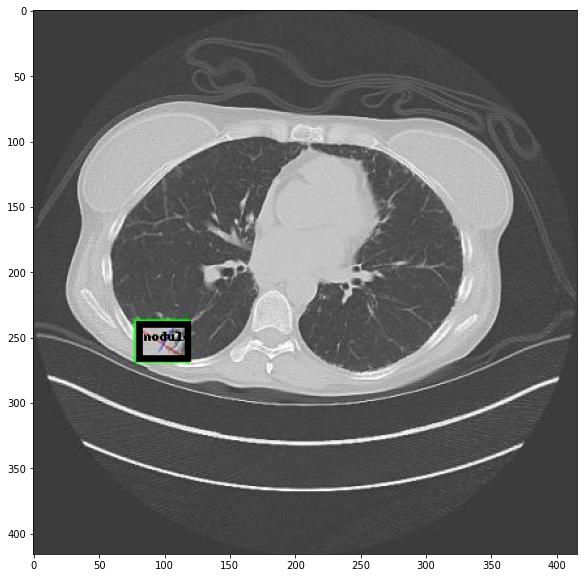

In [11]:
#! drawing predicted bounding boxex for single image instance
#! setting model to eval state, so dropout and batchnorms will be disabled:
model.eval()
torch.cuda.empty_cache()
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)

with torch.no_grad():
    #! make a prediction:
    prediction = model([img.to(DEVICE)])
    pred = prediction[0]

#! draw predictions using draw_bounding_boxes function of pytorch:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=5
).permute(1, 2, 0))